# 10장 MNIST를 활용한 숫자 인식

* "부록3 매트플롯립 입문"에서 한글 폰트를 올바르게 출력하기 위한 설치 방법을 설명했다. 설치 방법은 다음과 같다.

In [1]:
# 한글 폰트 설치

# !sudo apt-get install -y fonts-nanum* | tail -n 1
# !sudo fc-cache -fv
# !rm -rf ~/.cache/matplotlib

In [2]:
# # 필요 라이브러리 설치

# !pip install torchviz | tail -n 1
# !pip install torchinfo | tail -n 1

* 모든 설치가 끝나면 한글 폰트를 바르게 출력하기 위해 **[런타임]** -> **[런타임 다시시작]**을 클릭한 다음, 아래 셀부터 코드를 실행해 주십시오.

In [3]:
# 라이브러리 임포트

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# 폰트 관련 용도
import matplotlib.font_manager as fm

# Colab, Linux
# 나눔 고딕 폰트의 경로 명시
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()

# Window
# font_name = "NanumBarunGothic"

# Mac
# font_name = "AppleGothic"

In [4]:
# 파이토치 관련 라이브러리
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchviz import make_dot
from torchinfo import summary
# from tqdm.notebook import tqdm

import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [5]:
# 기본 폰트 설정
# 윈도우에서는 "malgun.ttf" 혹은 "NanumBarunGothic.ttf" 등을 사용할 수 있다. 맥에서는 "AppleGothic.ttf"
plt.rcParams['font.family'] = font_name

# 기본 폰트 사이즈 변경
plt.rcParams['font.size'] = 14

# 기본 그래프 사이즈 변경
plt.rcParams['figure.figsize'] = (6,6)

# 기본 그리드 표시
# 필요에 따라 설정할 때는, plt.grid()
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = ':'


# 마이너스 기호 정상 출력
plt.rcParams['axes.unicode_minus'] = False

# 넘파이 부동소수점 자릿수 표시
np.set_printoptions(suppress=True, precision=4)

## MNIST 숫자 인식

### 활성화 함수와 ReLU 함수

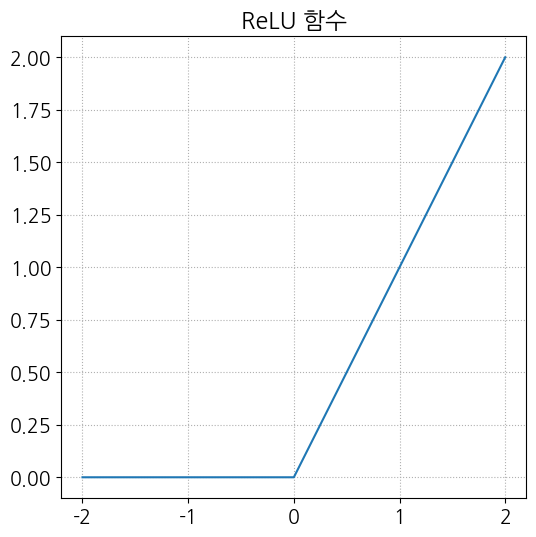

In [6]:
# ReLU 함수의 그래프

relu = nn.ReLU()
x_np = np.arange(-2, 2.1, 0.25)
x = torch.tensor(x_np).float()
y = relu(x)

plt.plot(x.data, y.data)
plt.title('ReLU 함수')
plt.show()

### GPU 디바이스 확인

In [7]:
# 디바이스 할당
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [8]:
# 텐서 변수 x, y
x_np = np.arange(-2.0, 2.1, 0.25)
y_np = np.arange(-1.0, 3.1, 0.25)
x = torch.tensor(x_np).float()
y = torch.tensor(y_np).float()

# x와 y 사이의 연산
z = x * y
print(z)

x= x.to(device)
print("x device =",x.device)

tensor([ 2.0000,  1.3125,  0.7500,  0.3125, -0.0000, -0.1875, -0.2500, -0.1875,
         0.0000,  0.3125,  0.7500,  1.3125,  2.0000,  2.8125,  3.7500,  4.8125,
         6.0000])
x device = cpu


In [9]:
# 변수 x를 GPU로 보냄
x = x.to(device)

# 변수 x와 y의 디바이스 속성 확인
print('x: ', x.device)
print('y: ', y.device)

x:  cpu
y:  cpu


In [10]:
# 이 상태에서 x와 y의 연산을 수행하면...

z = x * y

In [11]:
# y도 GPU로 보냄
y = y.to(device)

# 연산이 가능해짐
z = x * y
print(z)
print("z.device = ", z.device)

tensor([ 2.0000,  1.3125,  0.7500,  0.3125, -0.0000, -0.1875, -0.2500, -0.1875,
         0.0000,  0.3125,  0.7500,  1.3125,  2.0000,  2.8125,  3.7500,  4.8125,
         6.0000])
z.device =  cpu


### MNIST Dataset을 활용해 불러오기

In [12]:
# 라이브러리 임포트
import torchvision.datasets as datasets

# 다운로드받을 디렉터리명
data_root = './data'

train_set0 = datasets.MNIST(
    # 원본 데이터를 다운로드받을 디렉터리 지정
    root = data_root,
    # 훈련 데이터인지 또는 검증 데이터인지
    train = True,
    # 원본 데이터가 없는 경우, 다운로드를 실행하는지 여부
    download = True)

In [13]:
# 다운로드한 파일 확인
# 리눅스 명령어
!ls -lR ./data/MNIST

# Window 명령어
# !dir /s data\MNIST

./data/MNIST:
합계 4
drwxrwxr-x 2 rokey rokey 4096  5월  2 15:11 raw

./data/MNIST/raw:
합계 65012
-rw-rw-r-- 1 rokey rokey  7840016  5월  2 15:11 t10k-images-idx3-ubyte
-rw-rw-r-- 1 rokey rokey  1648877  5월  2 15:11 t10k-images-idx3-ubyte.gz
-rw-rw-r-- 1 rokey rokey    10008  5월  2 15:11 t10k-labels-idx1-ubyte
-rw-rw-r-- 1 rokey rokey     4542  5월  2 15:11 t10k-labels-idx1-ubyte.gz
-rw-rw-r-- 1 rokey rokey 47040016  5월  2 15:11 train-images-idx3-ubyte
-rw-rw-r-- 1 rokey rokey  9912422  5월  2 15:11 train-images-idx3-ubyte.gz
-rw-rw-r-- 1 rokey rokey    60008  5월  2 15:11 train-labels-idx1-ubyte
-rw-rw-r-- 1 rokey rokey    28881  5월  2 15:11 train-labels-idx1-ubyte.gz


In [14]:
# 데이터 건수 확인
print("train_set0 타입:", type(train_set0))
print("train_set0 : \n", train_set0)
print('데이터 건수: ', len(train_set0))


# 첫번째 요소 가져오기
image, label = train_set0[0] #tuple 

# 데이터 타입 확인
print("="*50)
print('입력 데이터 타입 : ', type(image)) # <class 'PIL.Image.Image'>
print('정답 데이터 타입 : ', type(label)) # <class 'int'>

print("max = ", np.array(image).max())
print("min = ", np.array(image).min())


train_set0 타입: <class 'torchvision.datasets.mnist.MNIST'>
train_set0 : 
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
데이터 건수:  60000
입력 데이터 타입 :  <class 'PIL.Image.Image'>
정답 데이터 타입 :  <class 'int'>
max =  255
min =  0


In [15]:
# 입력 데이터를 이미지로 출력

image_np =np.array(image)  #np.ndarray
print(image_np) #image를 배열로써 
print(image_np.dtype)
print(image_np.max())
print(image_np.min())

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

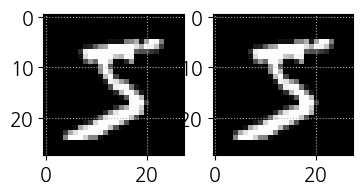

In [16]:
## plt.subplot

plt.figure(figsize=(4, 2))
plt.subplot(1,2,1), plt.imshow(image, cmap = 'gray')
plt.subplot(1,2,2), plt.imshow(image, cmap = 'gray')
plt.show()


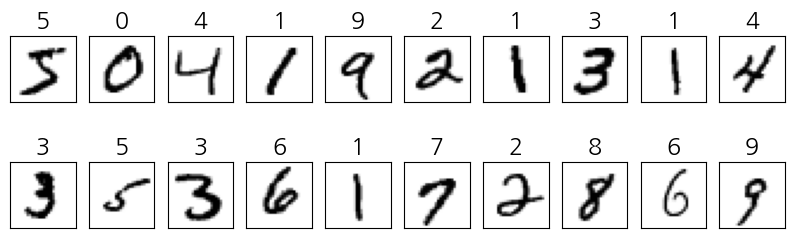

In [17]:
# 정답 데이터와 함께 처음 20개 데이터를 이미지로 출력

plt.figure(figsize=(10, 3))
for i in range(20): #20장 
    ax = plt.subplot(2, 10, i + 1)

    # image와 label 취득
    image, label = train_set0[i]

    # 이미지 출력
    plt.imshow(image, cmap='gray_r') #gray_r 보기 편하게, 딥러닝 시에는 gray가 맞음  
    ax.set_title(f'{label}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Transforms를 활용한 데이터 전처리

In [18]:
# 라이브러리 임포트
# import torchvision.transforms as transforms

transform1 = transforms.Compose([
    # 데이터를 텐서로 변환
    transforms.ToTensor()  #min-max 정규화 
])

train_set1 = datasets.MNIST(
    root=data_root,
    train=True,
    download=True,
    transform = transform1)

In [19]:
# 라이브러리 임포트
import torchvision.datasets as datasets

# 다운로드받을 디렉터리명
data_root = './data'

train_set = datasets.MNIST(
    # 원본 데이터를 다운로드받을 디렉터리 지정
    root = data_root,
    # 훈련 데이터인지 또는 검증 데이터인지
    train = True,
    # 원본 데이터가 없는 경우, 다운로드를 실행하는지 여부
    download = True)

In [20]:
# 변환 결과 확인

image, label = train_set1[0]
print('입력 데이터 타입 : ', type(image)) # <class 'torch.Tensor'>
print('입력 데이터 shape : ', image.shape)
print('최솟값 : ', image.data.min())
print('최댓값 : ', image.data.max())

입력 데이터 타입 :  <class 'torch.Tensor'>
입력 데이터 shape :  torch.Size([1, 28, 28])
최솟값 :  tensor(0.)
최댓값 :  tensor(1.)


### Normalize 사용 하기

In [21]:
## 순서 중요###
transform2 = transforms.Compose([
    # 데이터를 텐서로 변환
    transforms.ToTensor(),

    # 데이터 정규화
    transforms.Normalize(mean = 0.5,  std = 0.5), # z-transform #z-정규화 
])

train_set2 = datasets.MNIST(
    root = data_root,
    train = True,
    download = True,
    transform = transform2)

In [22]:
# 변환 결과 확인

image, label = train_set2[0]
print('shape : ', image.shape)
print('최솟값 : ', image.data.min())
print('최댓값 : ', image.data.max())

shape :  torch.Size([1, 28, 28])
최솟값 :  tensor(-1.)
최댓값 :  tensor(1.)


### 람다 표현식을 활용한 함수 정의

In [23]:
def f(x):
    return 1/np.exp(-10*x)


lambda x: 1/np.exp(-10*x)

<function __main__.<lambda>(x)>

In [24]:
# 일반적인 함수의 정의

def f(x):
    return (2 * x**2 + 2)

x = np.arange(-2, 2.1, 0.25)
y = f(x)
print(y)


# 람다 표현식으로 함수 정의
print("="*50)
g = lambda x: 2 * x**2 + 2

y = g(x)
print(y)

[10.     8.125  6.5    5.125  4.     3.125  2.5    2.125  2.     2.125
  2.5    3.125  4.     5.125  6.5    8.125 10.   ]
[10.     8.125  6.5    5.125  4.     3.125  2.5    2.125  2.     2.125
  2.5    3.125  4.     5.125  6.5    8.125 10.   ]


### Lambda 클래스를 사용해 1차원으로 텐서 변환하기

In [25]:
transform = transforms.Compose([
    # 데이터를 텐서로 변환
    transforms.ToTensor(),

    # 데이터 정규화
    transforms.Normalize(0.5, 0.5),

    # 현재 텐서를 1계 텐서로 변환
    transforms.Lambda(lambda x: x.view(-1))

])

train_set = datasets.MNIST(
    root = data_root,
    train = True,
    download=True,
    transform = transform)

In [26]:
transform3 = transforms.Compose([
    # 데이터를 텐서로 변환
    transforms.ToTensor(),

    # 데이터 정규화
    transforms.Normalize(0.5, 0.5),

    # 현재 텐서를 1계 텐서로 변환
    transforms.Lambda(lambda x: x.view(-1)),
])

train_set3 = datasets.MNIST(
    root = data_root,
    train = True,
    download=True,
    transform = transform3)

In [27]:
# 변환 결과 확인

image, label = train_set3[0]
print('shape : ', image.shape)
print('최솟값 : ', image.data.min())
print('최댓값 : ', image.data.max())

shape :  torch.Size([784])
최솟값 :  tensor(-1.)
최댓값 :  tensor(1.)


### 최종 구현 형태

In [28]:
# 데이터 변환용 함수 Transforms
# (1) Image를 텐서화
# (2) [0, 1] 범위의 값을 [-1, 1] 범위로 조정
# (3) 데이터의 shape을 [1, 28, 28] 에서 [784] 로 변환

transform = transforms.Compose([
    # (1) 데이터를 텐서로 변환
    transforms.ToTensor(),

    # (2) 데이터 정규화
    transforms.Normalize(0.5, 0.5),

    # (3) 1계 텐서로 변환
    transforms.Lambda(lambda x: x.view(-1)),
])

In [29]:
# 데이터 입수를 위한 Dataset 함수

# 훈련용 데이터셋 정의
train_set = datasets.MNIST(
    root = data_root,
    train = True,
    download = True,
    transform = transform)

# 검증용 데이터셋 정의
test_set = datasets.MNIST(
    root = data_root,
    train = False,
    download = True,
    transform = transform)

### 데이터로더를 활용한 미니 배치 데이터 생성

In [30]:
from torchvision import transforms

transform1 = transforms.Compose([
    transforms.ToTensor()
])

In [31]:
# 라이브러리 임포트
from torch.utils.data import DataLoader

# 미니 배치 사이즈 지정
batch_size = 500

# 훈련용 데이터로더
# 훈련용이므로, 셔플을 적용함
train_loader = DataLoader(
    dataset = train_set,
    batch_size = batch_size,
    shuffle = True)

# 검증용 데이터로더
# 검증시에는 셔플을 필요로하지 않음
test_loader = DataLoader(
    dataset = test_set,
    batch_size = batch_size,
    shuffle = False)

In [32]:
# 몇 개의 그룹으로 데이터를 가져올 수 있는가
# images, labels = next(iter(train_loader))

print(len(train_loader))

# 데이터로더로부터 가장 처음 한 세트를 가져옴
for images, labels in train_loader:
    break

print(images.shape)
print(labels.shape)

# print("max value = ", images.max())

120
torch.Size([500, 784])
torch.Size([500])


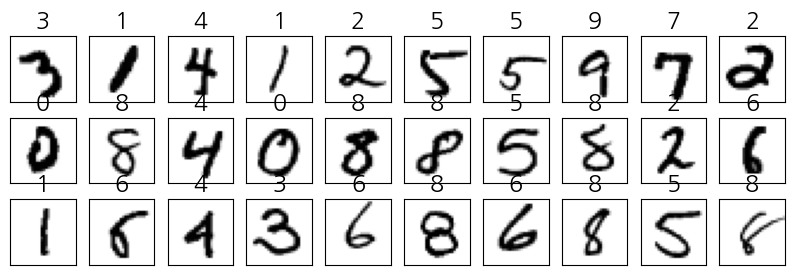

In [33]:
# 이미지 출력
plt.figure(figsize=(10, 3))
# fig, axs = plt.subplots(2, 10, figsize = (10, 3))

for i in range(30):
    ax = plt.subplot(3, 10, i + 1)

    # row = i//10
    # col = i % 10

    # 넘파이로 배열로 변환
    image = images[i].numpy()
    label = labels[i]

    # 이미지의 범위를 [0, 1] 로 되돌림
    image2 = (image + 1)/ 2

    # 이미지 출력
    plt.imshow(image2.reshape(28, 28), cmap='gray_r') 
    # ax.set_title(str(label.item()))
    ax.set_title(f'{label}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # axs[row, col].imshow(image2.reshape(28, 28), cmap='gray_r')
    # axs[row, col].set_title(f'{label}')
    # axs[row, col].get_xaxis().set_visible(False)
    # axs[row, col].get_yaxis().set_visible(False)
plt.show()

### 모델 정의

In [34]:
# 입력 차원수
n_input = image.shape[0] #784
# 출력 차원수
# 분류 클래스 수는 10
n_output = len(set(list(labels.data.numpy()))) #10

# 은닉층의 노드 수
n_hidden = 128 #임의로 설정 

# 결과 확인
print(f'n_input: {n_input}  n_hidden: {n_hidden} n_output: {n_output}')

n_input: 784  n_hidden: 128 n_output: 10


In [35]:
# 모델 정의
# 784입력 10출력 1은닉층의 신경망 모델

class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        # 은닉층 정의(은닉층 노드 수 : n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)

        # 출력층 정의
        self.l2 = nn.Linear(n_hidden, n_output)

        # ReLU 함수 정의
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

In [36]:
# 난수 고정
torch.manual_seed(123)
torch.cuda.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

# 모델 인스턴스 생성
net = Net(n_input, n_output, n_hidden) #cpu

# 모델을 GPU로 전송
net = net.to(device) #gpu
# next(net.parameters()).is_cuda

In [73]:
!pip install torchinfo


In [38]:
from torchinfo import summary

summary(net, (100,784), device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [100, 10]                 --
├─Linear: 1-1                            [100, 128]                100,480
├─ReLU: 1-2                              [100, 128]                --
├─Linear: 1-3                            [100, 10]                 1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 10.18
Input size (MB): 0.31
Forward/backward pass size (MB): 0.11
Params size (MB): 0.41
Estimated Total Size (MB): 0.83

In [39]:
print(net)

Net(
  (l1): Linear(in_features=784, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [40]:
# 학습률
lr = 0.01

# 최적화 알고리즘: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

In [41]:
# 모델 내부 파라미터 확인
# l1.weight, l1.bias, l2.weight, l2.bias를 확인할 수 있음
#batch : 120 
for image, labels in train_loader:
    break
print(image.shape)
print(labels.shape)

for parameter in net.named_parameters():
    print(parameter)

# list(net.named_parameters())[0][1].data.cpu().numpy()

torch.Size([500, 784])
torch.Size([500])
('l1.weight', Parameter containing:
tensor([[-0.0146,  0.0012, -0.0177,  ...,  0.0277,  0.0200,  0.0315],
        [ 0.0184, -0.0322,  0.0175,  ...,  0.0089, -0.0028, -0.0033],
        [ 0.0092,  0.0261,  0.0075,  ...,  0.0061,  0.0267, -0.0258],
        ...,
        [ 0.0235, -0.0026, -0.0129,  ...,  0.0322, -0.0059, -0.0169],
        [-0.0328, -0.0258,  0.0124,  ..., -0.0049,  0.0006,  0.0334],
        [ 0.0187, -0.0076, -0.0202,  ...,  0.0325, -0.0159, -0.0240]],
       requires_grad=True))
('l1.bias', Parameter containing:
tensor([ 0.0325, -0.0298,  0.0013,  0.0199,  0.0268, -0.0248, -0.0172, -0.0355,
         0.0122, -0.0048,  0.0214,  0.0202, -0.0243,  0.0015, -0.0276,  0.0296,
         0.0341, -0.0228,  0.0230,  0.0347, -0.0091, -0.0346,  0.0206, -0.0060,
         0.0329,  0.0047,  0.0180,  0.0101,  0.0177, -0.0309,  0.0228, -0.0224,
         0.0321,  0.0179,  0.0321,  0.0184,  0.0219, -0.0089,  0.0310, -0.0039,
        -0.0074, -0.0317,  

In [42]:
##
net=Net(n_input, n_output,n_hidden).to(device) #GPU

lr =0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=lr)

num_epochs= 10 #batch 500=>5000
history = np.zeros((0,5))

In [43]:
# 모델 개요 표시 1

print(net)

Net(
  (l1): Linear(in_features=784, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [44]:
# 모델 개요 표시 2

summary(net, (784,))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [10]                      --
├─Linear: 1-1                            [128]                     100,480
├─ReLU: 1-2                              [128]                     --
├─Linear: 1-3                            [10]                      1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 12.87
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.41
Estimated Total Size (MB): 0.41

### 경사 하강법

In [45]:
# 훈련 데이터셋의 가장 처음 항목을 취득
# 데이터로더에서 가장 처음 항목을 취득
for images, labels in train_loader:
    break

In [46]:
# 데이터로더에서 취득한 데이터를 GPU로 보냄
inputs = images.to(device)
labels = labels.to(device)

In [47]:
# 예측 계산
outputs = net(inputs)

# 결과 확인
print(outputs)


tensor([[-0.4052, -0.2885,  0.1173,  ..., -0.0412,  0.0182,  0.3327],
        [-0.4563, -0.4921,  0.1501,  ..., -0.1633,  0.0096,  0.0586],
        [-0.4354, -0.3343,  0.1200,  ..., -0.0558,  0.0597, -0.0671],
        ...,
        [-0.3874, -0.5574, -0.0206,  ..., -0.1073,  0.0423,  0.1060],
        [-0.4624, -0.4687,  0.1107,  ..., -0.3101, -0.1011,  0.2048],
        [-0.3574, -0.5001,  0.1110,  ..., -0.1343,  0.0681,  0.1419]],
       grad_fn=<AddmmBackward0>)


tensor(2.3492, grad_fn=<NllLossBackward0>)


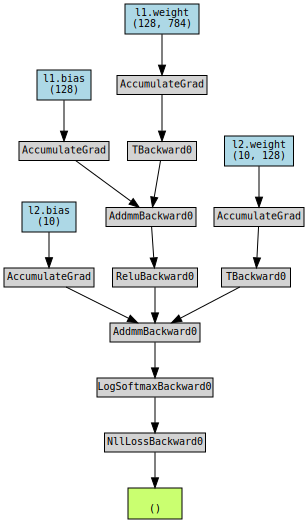

In [48]:
#  손실 계산
loss = criterion(outputs, labels)

# 손실값 가져오기
print(loss)

# 손실 계산 그래프 시각화
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

### 경사 계산

In [49]:
next(net.parameters()).is_cuda

False

In [50]:
# 경사 계산 실행
loss.backward()

In [51]:
# 경사 계산 결과
w = net.to('cpu')
print(w.l1.weight.grad.numpy())
print(w.l1.bias.grad.numpy())
print(w.l2.weight.grad.numpy())
print(w.l2.bias.grad.numpy())

[[-0.0019 -0.0019 -0.0019 ... -0.0019 -0.0019 -0.0019]
 [-0.014  -0.014  -0.014  ... -0.014  -0.014  -0.014 ]
 [ 0.0038  0.0038  0.0038 ...  0.0038  0.0038  0.0038]
 ...
 [-0.0007 -0.0007 -0.0007 ... -0.0007 -0.0007 -0.0007]
 [ 0.0002  0.0002  0.0002 ...  0.0002  0.0002  0.0002]
 [ 0.0018  0.0018  0.0018 ...  0.0018  0.0018  0.0018]]
[ 0.0019  0.014  -0.0038  0.001   0.     -0.0001  0.0015  0.     -0.0002
 -0.0015 -0.0027  0.0016 -0.0016  0.      0.      0.0013 -0.007   0.
 -0.0001 -0.0064  0.0015 -0.0014  0.0002  0.0005 -0.0011 -0.0095  0.0024
 -0.0068 -0.0081  0.0006  0.0033 -0.0062  0.0007  0.0111 -0.0027  0.0044
  0.0095  0.002   0.0146  0.0009  0.0073 -0.0047 -0.002   0.0008  0.0084
  0.0048  0.003  -0.0011  0.005   0.0017 -0.0014 -0.001  -0.0009  0.0036
 -0.0056 -0.0041  0.0004 -0.0029 -0.0021 -0.0024  0.0014  0.0001  0.0004
  0.0055  0.002   0.0082  0.0003  0.0015  0.0015  0.0002 -0.0026 -0.0004
  0.0005 -0.0043  0.005  -0.0032  0.0064  0.008  -0.0024  0.0108  0.0006
 -0.0011 -0

### 파라미터 수정

In [52]:
# 경사 하강법 적용
optimizer.step()

In [53]:
# 파라미터 값 출력
print(net.l1.weight)
print(net.l1.bias)

Parameter containing:
tensor([[-0.0312, -0.0097,  0.0217,  ..., -0.0049, -0.0021, -0.0307],
        [ 0.0264,  0.0169, -0.0119,  ...,  0.0085, -0.0296, -0.0273],
        [ 0.0015, -0.0281, -0.0344,  ..., -0.0332, -0.0052,  0.0161],
        ...,
        [ 0.0263,  0.0050, -0.0016,  ..., -0.0108,  0.0005,  0.0248],
        [ 0.0216,  0.0213,  0.0155,  ..., -0.0280, -0.0021,  0.0250],
        [-0.0313, -0.0209, -0.0013,  ...,  0.0062,  0.0161,  0.0324]],
       requires_grad=True)
Parameter containing:
tensor([-0.0060,  0.0051, -0.0009,  0.0076,  0.0117,  0.0084, -0.0023,  0.0124,
        -0.0068, -0.0220,  0.0313, -0.0139,  0.0159, -0.0147, -0.0044,  0.0288,
        -0.0059, -0.0098,  0.0280,  0.0265, -0.0342, -0.0238, -0.0086,  0.0090,
        -0.0291, -0.0051,  0.0072, -0.0208, -0.0148, -0.0279,  0.0286, -0.0078,
        -0.0138,  0.0013,  0.0231, -0.0153,  0.0004,  0.0304,  0.0316,  0.0282,
         0.0211, -0.0205,  0.0179,  0.0159, -0.0180,  0.0017, -0.0210,  0.0130,
         0.0338

### 반복 계산

In [54]:
# 난수 고정
torch.manual_seed(123)
torch.cuda.manual_seed(123)


# 학습률
lr = 0.01

# 모델 초기화
net = Net(n_input, n_output, n_hidden).to(device)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 반복 횟수
# num_epochs = 100
num_epochs = 10


# 평가 결과 기록
history = np.zeros((0,5))

In [75]:
pip install tqdm


Note: you may need to restart the kernel to use updated packages.


In [76]:
# tqdm 라이브러리 임포트
# from tqdm.notebook import tqdm
from tqdm import tqdm

# 반복 계산 메인 루프
for epoch in range(num_epochs): #10 
    train_acc, train_loss = 0, 0
    val_acc, val_loss = 0, 0
    n_train, n_test = 0, 0

    # 훈련 페이즈
    for inputs, labels in tqdm(train_loader): ##60000/500 =120 mini-batch
        n_train += len(labels)

        # GPU로 전송
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 경사 초기화
        optimizer.zero_grad()

        # 예측 계산
        outputs = net(inputs)

        # 손실 계산
        loss = criterion(outputs, labels)

        # 경사 계산
        loss.backward()

        # 파라미터 수정
        optimizer.step()

        # 예측 라벨 산출
        predicted = torch.max(outputs, 1)[1]

        # 손실과 정확도 계산
        train_loss += loss.item()
        train_acc += (predicted == labels).float().mean()

    # 예측 페이즈
    for inputs_test, labels_test in test_loader:
        n_test += len(labels_test)

        inputs_test = inputs_test.to(device)
        labels_test = labels_test.to(device)


        # 예측 계산
        outputs_test = net(inputs_test)

        # 손실 계산
        loss_test = criterion(outputs_test, labels_test)

        # 예측 라벨 산출
        predicted_test = torch.max(outputs_test, 1)[1]

        # 손실과 정확도 계산
        val_loss +=  loss_test.item()
        val_acc +=  (predicted_test == labels_test).sum().item()

    # 평가 결과 산출, 기록
    train_acc = train_acc / n_train
    val_acc = val_acc / n_test
    train_loss = train_loss * batch_size / n_train
    val_loss = val_loss * batch_size / n_test
    print (f'Epoch [{epoch+1}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
    item = np.array([epoch+1 , train_loss, train_acc, val_loss, val_acc])
    history = np.vstack((history, item))

  0%|          | 0/120 [00:00<?, ?it/s]

100%|██████████| 120/120 [00:11<00:00, 10.86it/s]


Epoch [1/10], loss: 2.20163 acc: 0.00051 val_loss: 2.04576, val_acc: 0.49800


100%|██████████| 120/120 [00:10<00:00, 11.56it/s]


Epoch [2/10], loss: 1.75820 acc: 0.00121 val_loss: 1.39272, val_acc: 0.68680


100%|██████████| 120/120 [00:10<00:00, 11.30it/s]


Epoch [3/10], loss: 1.11284 acc: 0.00151 val_loss: 0.86510, val_acc: 0.80810


100%|██████████| 120/120 [00:11<00:00, 10.84it/s]


Epoch [4/10], loss: 0.75170 acc: 0.00165 val_loss: 0.63477, val_acc: 0.84380


100%|██████████| 120/120 [00:10<00:00, 11.68it/s]


Epoch [5/10], loss: 0.59030 acc: 0.00170 val_loss: 0.52462, val_acc: 0.86370


100%|██████████| 120/120 [00:10<00:00, 11.44it/s]


Epoch [6/10], loss: 0.50672 acc: 0.00173 val_loss: 0.46400, val_acc: 0.87440


100%|██████████| 120/120 [00:10<00:00, 11.28it/s]


Epoch [7/10], loss: 0.45680 acc: 0.00175 val_loss: 0.42148, val_acc: 0.88560


100%|██████████| 120/120 [00:10<00:00, 11.60it/s]


Epoch [8/10], loss: 0.42335 acc: 0.00176 val_loss: 0.39551, val_acc: 0.89020


100%|██████████| 120/120 [00:11<00:00, 10.84it/s]


Epoch [9/10], loss: 0.39965 acc: 0.00178 val_loss: 0.37600, val_acc: 0.89350


100%|██████████| 120/120 [00:10<00:00, 11.80it/s]


Epoch [10/10], loss: 0.38195 acc: 0.00178 val_loss: 0.35886, val_acc: 0.89880


### 결과 확인

In [77]:
# 손실과 정확도 확인

print(f'초기상태 : 손실 : {history[0,3]:.5f}  정확도 : {history[0,4]:.5f}' )
print(f'최종상태 : 손실 : {history[-1,3]:.5f}  정확도 : {history[-1,4]:.5f}' )

초기상태 : 손실 : 2.04576  정확도 : 0.49800
최종상태 : 손실 : 0.35886  정확도 : 0.89880


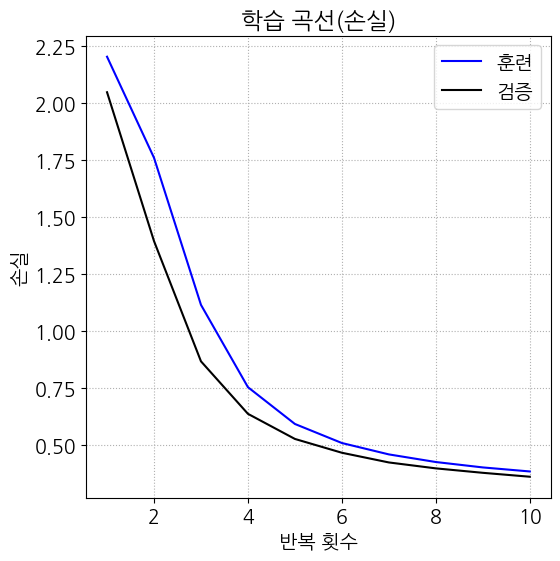

In [78]:
# 학습 곡선 출력(손실)

plt.plot(history[:,0], history[:,1], 'b', label='훈련')
plt.plot(history[:,0], history[:,3], 'k', label='검증')
plt.xlabel('반복 횟수')
plt.ylabel('손실')
plt.title('학습 곡선(손실)')
plt.legend()
plt.show()

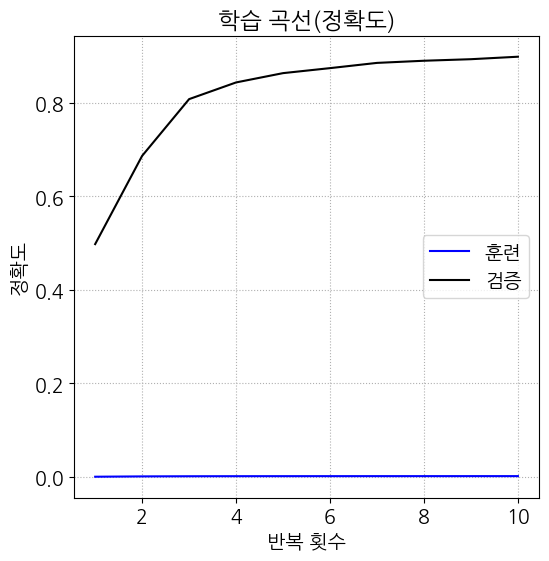

In [79]:
# 학습 곡선 출력(정확도)

plt.plot(history[:,0], history[:,2], 'b', label='훈련')
plt.plot(history[:,0], history[:,4], 'k', label='검증')
plt.xlabel('반복 횟수')
plt.ylabel('정확도')
plt.title('학습 곡선(정확도)')
plt.legend()
plt.show()

### 이미지 출력 확인

In [80]:
# 데이터로더에서 처음 한 세트 가져오기
for images, labels in test_loader:
    break

# 예측 결과 가져오기
inputs = images.to(device)
labels = labels.to(device)
outputs = net(inputs)
predicted = outputs.argmax(-1) 
predicted
# predicted = torch.max(outputs, 1)[1]

tensor([7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 6, 7, 2, 7, 1, 3, 1, 1, 7, 4, 2, 3, 5, 3, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 4, 2, 7, 4, 2, 4, 3, 0, 7, 0,
        2, 7, 1, 7, 3, 7, 9, 7, 9, 6, 2, 7, 8, 4, 7, 5, 6, 1, 3, 6, 4, 3, 1, 4,
        1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 1, 3, 9, 7, 4, 4, 4, 9, 2,
        5, 4, 7, 6, 4, 9, 0, 5, 8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1,
        7, 1, 8, 2, 0, 9, 9, 9, 5, 5, 1, 5, 6, 0, 3, 4, 4, 6, 5, 4, 6, 5, 4, 5,
        1, 4, 4, 7, 3, 3, 2, 7, 1, 8, 1, 8, 1, 8, 5, 0, 8, 9, 2, 3, 0, 1, 1, 1,
        0, 9, 0, 3, 1, 6, 4, 2, 3, 6, 1, 1, 1, 3, 9, 5, 2, 9, 4, 5, 9, 3, 9, 0,
        3, 5, 5, 5, 7, 2, 2, 7, 1, 2, 8, 4, 1, 7, 3, 3, 8, 7, 7, 7, 2, 2, 4, 1,
        5, 8, 8, 7, 2, 5, 0, 2, 4, 2, 4, 1, 9, 5, 7, 7, 2, 8, 2, 0, 8, 1, 7, 7,
        3, 1, 8, 1, 5, 0, 3, 0, 1, 9, 9, 4, 1, 8, 2, 1, 2, 9, 7, 5, 9, 2, 6, 4,
        1, 5, 5, 2, 9, 2, 0, 4, 0, 0, 2,

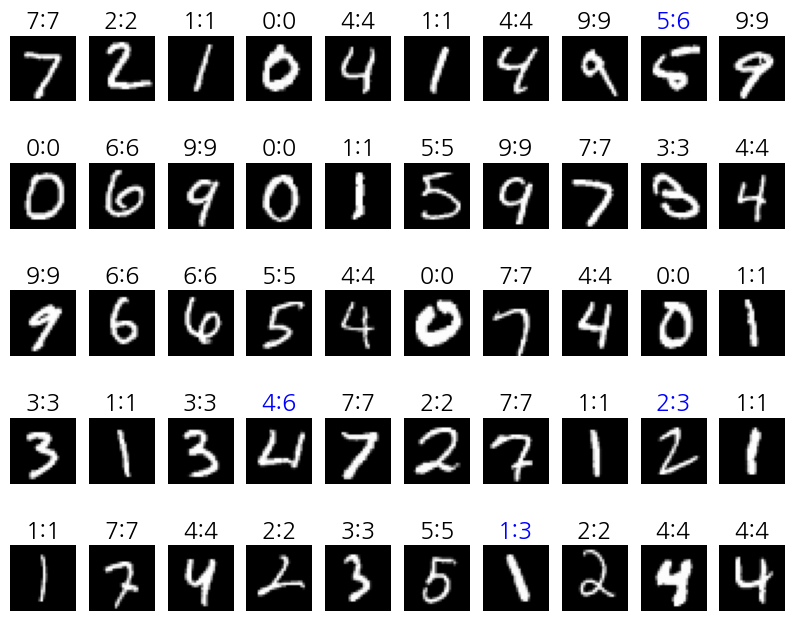

In [81]:
# 처음 50건의 이미지에 대해 "정답:예측"으로 출력

plt.figure(figsize=(10, 8))
for i in range(50):
  ax = plt.subplot(5, 10, i + 1)

  # 넘파이 배열로 변환
  image = images[i].numpy()
  label = labels[i]
  pred = predicted[i]

  if (pred == label):
    c = 'k'
  else:
    c = 'b'

  # 이미지의 범위를 [0, 1] 로 되돌림
  image2 = (image + 1)/ 2 #-1에서 1로 바꿔 놨었음.

  # 이미지 출력
  plt.imshow(image2.reshape(-1, 28),cmap='gray')
  plt.title(f'{label}:{pred}', c=c)
  plt.axis("off")
  
plt.show()

### 은닉층 추가하기

In [82]:
# 모델 정의
# 784입력 10출력을 갖는 2개의 은닉층을 포함한 신경망

class Net2(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        # 첫번째 은닉층 정의(은닉층 노드 수: n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)

        # 두번째 은닉층 정의(은닉층 노드 수: n_hidden)
        self.l2 = nn.Linear(n_hidden, n_hidden)

        # 출력층 정의
        self.l3 = nn.Linear(n_hidden, n_output)

        # ReLU 함수 정의
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        x4 = self.relu(x3)
        x5 = self.l3(x4)
        return x5

In [83]:
# 난수 고정
torch.manual_seed(123)
torch.cuda.manual_seed(123)

# 모델 초기화
net = Net2(n_input, n_output, n_hidden).to(device)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 최적화 함수: 경사 하강법
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [84]:
print(net)

Net2(
  (l1): Linear(in_features=784, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [85]:
# 모델 개요 표시 2

summary(net, (784,))

Layer (type:depth-idx)                   Output Shape              Param #
Net2                                     [10]                      --
├─Linear: 1-1                            [128]                     100,480
├─ReLU: 1-2                              [128]                     --
├─Linear: 1-3                            [128]                     16,512
├─ReLU: 1-4                              [128]                     --
├─Linear: 1-5                            [10]                      1,290
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 14.99
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.47
Estimated Total Size (MB): 0.48

In [86]:
# 데이터로더에서 처음 한 세트 가져오기
for images, labels in test_loader:
    break

# 예측 결과 가져오기
inputs = images.to(device)
labels = labels.to(device)

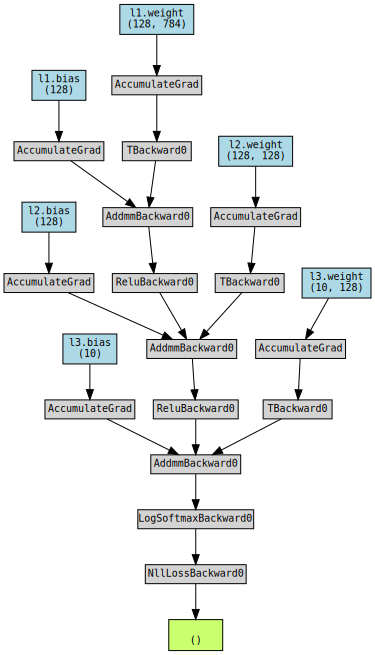

In [87]:
# 예측 계산
outputs = net(inputs)

# 손실 계산
loss = criterion(outputs, labels)

# 손실 계산 그래프 시각화
make_dot(loss, params=dict(net.named_parameters()))

### 경사 계산

In [88]:
# 경사 계산
loss.backward()

# 경사 계산 결과 일부
w = net.to('cpu').l1.weight.grad.numpy()
print("w = ", w)

# 각 요소의 절댓값 평균
print(np.abs(w).mean())

w =  [[-0.0007 -0.0007 -0.0007 ... -0.0007 -0.0007 -0.0007]
 [-0.0001 -0.0001 -0.0001 ... -0.0001 -0.0001 -0.0001]
 [-0.0005 -0.0005 -0.0005 ... -0.0005 -0.0005 -0.0005]
 ...
 [ 0.0015  0.0015  0.0015 ...  0.0015  0.0015  0.0015]
 [ 0.0002  0.0002  0.0002 ...  0.0002  0.0002  0.0002]
 [ 0.0003  0.0003  0.0003 ...  0.0003  0.0003  0.0003]]
0.0008487979


### 반복 계산

In [89]:
# 난수 고정
torch.manual_seed(123)
torch.cuda.manual_seed(123)


# 모델 초기화
net = Net2(n_input, n_output, n_hidden).to(device)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 반복 횟수
num_epochs = 10

# 평가 결과 기록
history2 = np.zeros((0,5))

In [90]:
# 반복 계산 메인 루프

for epoch in range(num_epochs):
    train_acc = 0
    train_loss = 0
    val_acc = 0
    val_loss = 0
    n_train = 0
    n_test = 0

    # 훈련 페이즈
    for inputs, labels in tqdm(train_loader):
        n_train += len(labels)

        # GPU로 전송
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 경사 초기화
        optimizer.zero_grad()

        # 예측 계산
        outputs = net(inputs)

        # 손실 계산
        loss = criterion(outputs, labels)

        # 경사 계산
        loss.backward()

        # 파라미터 수정
        optimizer.step()

        # 예측 라벨 산출
        predicted = torch.max(outputs, 1)[1]

        # 손실과 정확도 계산
        train_loss += loss.item()
        train_acc += (predicted == labels).sum().item()

    # 예측 페이즈
    for inputs_test, labels_test in test_loader:
        n_test += len(labels_test)

        inputs_test = inputs_test.to(device)
        labels_test = labels_test.to(device)

        # 예측 계산
        outputs_test = net(inputs_test)

        # 손실 계산
        loss_test = criterion(outputs_test, labels_test)

        # 예측 라벨 산출
        predicted_test = torch.max(outputs_test, 1)[1]

        # 손실과 정확도 계산
        val_loss +=  loss_test.item()
        val_acc +=  (predicted_test == labels_test).sum().item()

    # 평가 결과 산출, 기록
    train_acc = train_acc / n_train
    val_acc = val_acc / n_test
    train_loss = train_loss * batch_size / n_train
    val_loss = val_loss * batch_size / n_test
    print (f'Epoch [{epoch+1}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
    item = np.array([epoch+1 , train_loss, train_acc, val_loss, val_acc])
    history2 = np.vstack((history2, item))

100%|██████████| 120/120 [00:11<00:00, 10.82it/s]


Epoch [1/10], loss: 2.20163 acc: 0.25380 val_loss: 2.04576, val_acc: 0.49800


100%|██████████| 120/120 [00:10<00:00, 11.01it/s]


Epoch [2/10], loss: 1.75820 acc: 0.60443 val_loss: 1.39272, val_acc: 0.68680


100%|██████████| 120/120 [00:10<00:00, 11.65it/s]


Epoch [3/10], loss: 1.11284 acc: 0.75645 val_loss: 0.86510, val_acc: 0.80810


100%|██████████| 120/120 [00:10<00:00, 11.78it/s]


Epoch [4/10], loss: 0.75170 acc: 0.82300 val_loss: 0.63477, val_acc: 0.84380


100%|██████████| 120/120 [00:10<00:00, 11.16it/s]


Epoch [5/10], loss: 0.59030 acc: 0.84983 val_loss: 0.52462, val_acc: 0.86370


100%|██████████| 120/120 [00:10<00:00, 10.96it/s]


Epoch [6/10], loss: 0.50672 acc: 0.86653 val_loss: 0.46400, val_acc: 0.87440


100%|██████████| 120/120 [00:10<00:00, 11.49it/s]


Epoch [7/10], loss: 0.45680 acc: 0.87540 val_loss: 0.42148, val_acc: 0.88560


100%|██████████| 120/120 [00:10<00:00, 11.45it/s]


Epoch [8/10], loss: 0.42335 acc: 0.88193 val_loss: 0.39551, val_acc: 0.89020


100%|██████████| 120/120 [00:10<00:00, 11.53it/s]


Epoch [9/10], loss: 0.39965 acc: 0.88770 val_loss: 0.37600, val_acc: 0.89350


100%|██████████| 120/120 [00:10<00:00, 10.97it/s]


Epoch [10/10], loss: 0.38195 acc: 0.89187 val_loss: 0.35886, val_acc: 0.89880


In [91]:
# 손실과 정확도 확인

print(f'초기상태 : 손실 : {history2[0,3]:.5f}  정확도 : {history2[0,4]:.5f}' )
print(f'최종상태 : 손실 : {history2[-1,3]:.5f}  정확도 : {history2[-1,4]:.5f}' )

초기상태 : 손실 : 2.04576  정확도 : 0.49800
최종상태 : 손실 : 0.35886  정확도 : 0.89880


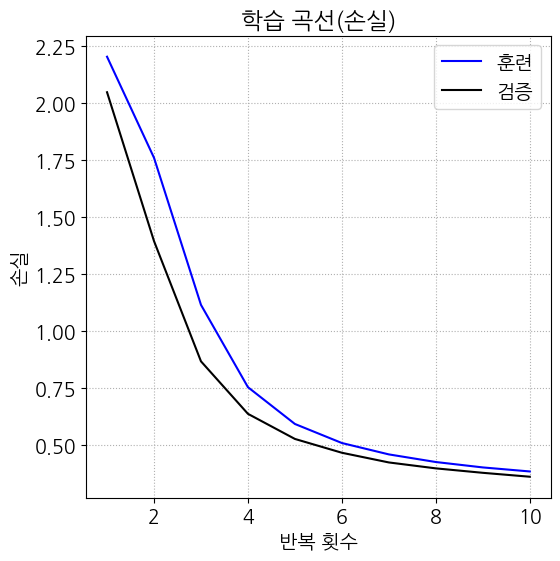

In [92]:
# 학습 곡선 출력(손실)
plt.plot(history2[:,0], history2[:,1], 'b', label='훈련')
plt.plot(history2[:,0], history2[:,3], 'k', label='검증')
plt.xlabel('반복 횟수')
plt.ylabel('손실')
plt.title('학습 곡선(손실)')
plt.legend()
plt.show()

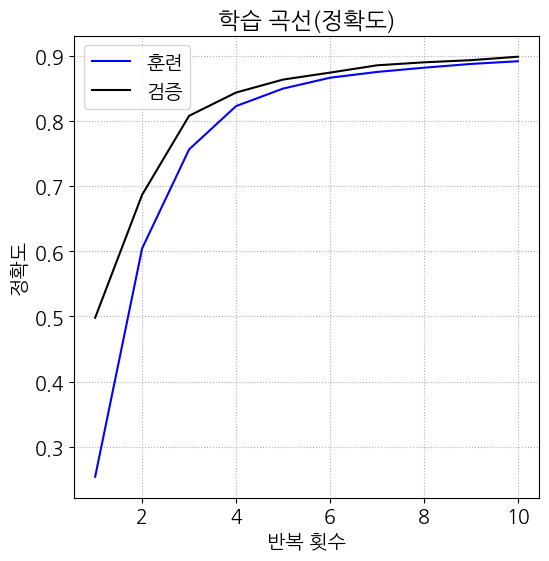

In [93]:
# 학습 곡선 출력(정확도)

plt.plot(history2[:,0], history2[:,2], 'b', label='훈련')
plt.plot(history2[:,0], history2[:,4], 'k', label='검증')
plt.xlabel('반복 횟수')
plt.ylabel('정확도')
plt.title('학습 곡선(정확도)')
plt.legend()
plt.show()

### 경사 소실과 ReLU 함수

In [94]:
# 모델 정의 -　시그모이드 함수 버전
# 784입력 10출력을 갖는 2개의 은닉층을 포함한 신경망
#Sigmoid를 썼을때의 손실 (ReLU함수롸 비교교)

class Net3(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        # 첫번째 은닉층 정의(은닉층 노드 수: n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)

        # 두번째 은닉층 정의(은닉층 노드 수: n_hidden)
        self.l2 = nn.Linear(n_hidden, n_hidden)

        # 출력층 정의
        self.l3 = nn.Linear(n_hidden, n_output)

        # 시그모이드 함수 정의
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.sigmoid(x1)
        x3 = self.l2(x2)
        x4 = self.sigmoid(x3)
        x5 = self.l3(x4)
        return x5

In [95]:
# 난수 고정
torch.manual_seed(123)
torch.cuda.manual_seed(123)

# 모델 초기화
net = Net3(n_input, n_output, n_hidden).to(device)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 최적화 함수: 경사 하강법
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [96]:
# 데이터로더에서 처음 한 세트 가져오기
for images, labels in test_loader:
    break

# 예측 결과 가져오기
inputs = images.to(device)
labels = labels.to(device)

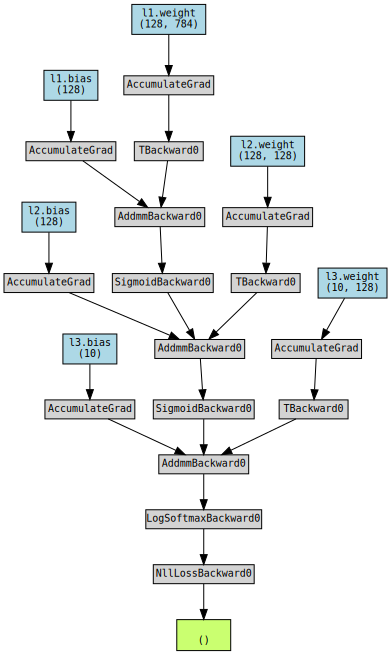

In [97]:
# 예측 계산
outputs = net(inputs)

# 손실 계산
loss = criterion(outputs, labels)

# 손실 계산 그래프 시각화
make_dot(loss, params=dict(net.named_parameters()))

In [98]:
# 경사 계산
loss.backward()

# 경사 계산 결과의 일부
w = net.to('cpu').l1.weight.grad.numpy()
print(w)

# 각 요소의 절댓값 평균
print(np.abs(w).mean())

[[ 0.0001  0.0001  0.0001 ...  0.0001  0.0001  0.0001]
 [ 0.0001  0.0001  0.0001 ...  0.0001  0.0001  0.0001]
 [-0.0001 -0.0001 -0.0001 ... -0.0001 -0.0001 -0.0001]
 ...
 [-0.0001 -0.0001 -0.0001 ... -0.0001 -0.0001 -0.0001]
 [ 0.0002  0.0002  0.0002 ...  0.0002  0.0002  0.0002]
 [-0.0001 -0.0001 -0.0001 ... -0.0001 -0.0001 -0.0001]]
0.00017514593


### 배치 사이즈와 정확도의 관계

In [99]:
# 학습용 함수
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):
    base_epochs = len(history)
    batch_size_train = len(train_loader)
    batch_size_test = len(test_loader)


    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        # 훈련 페이즈
        # count = 0

        for inputs, labels in tqdm(train_loader):

            # count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 경사 초기화
            optimizer.zero_grad()

            # 예측 계산
            outputs = net(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # 경사 계산
            loss.backward()

            # 파라미터 수정
            optimizer.step()

            # 예측 라벨 산출
            predicted = torch.max(outputs, 1)[1]

            # 정답 건수 산출
            train_acc += (predicted == labels).sum().item() /len(labels)

            # 훈련 데이터에 대해 손실과 정확도 계산
        avg_train_loss = train_loss / batch_size_train
        avg_train_acc = train_acc / batch_size_train

        # 예측 페이즈
        # count = 0

        for inputs, labels in test_loader:
            # count += len(labels)

            inputs = inputs.to(device)
            labels = labels.to(device)

            # 예측 계산
            outputs = net(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # 예측 라벨 산출
            predicted = torch.max(outputs, 1)[1]

            # 정답 건수 산출
            val_acc += (predicted == labels).sum().item() /len(labels)

            # 검증 데이터에 대해 손실과 정확도 계산
        avg_val_loss = val_loss / batch_size_test
        avg_val_acc = val_acc / batch_size_test

        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history

In [100]:
# 파이토치 난수 고정

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms(True)

### Batch size  500

In [101]:
# 미니 배치 사이즈 지정
batch_size_train = 500

# 훈련용 데이터로더
# 훈련용이므로 셔플을 적용함
train_loader = DataLoader(
    train_set,
    batch_size = batch_size_train,
    shuffle = True)

# 난수 고정
torch_seed()

# 학습률
lr = 0.01

# 모델 초기화
net = Net(n_input, n_output, n_hidden).to(device)

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 반복 횟수
num_epochs = 10

# 평가 결과 기록
history = np.zeros((0,5))

In [102]:
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

100%|██████████| 120/120 [00:09<00:00, 12.01it/s]


Epoch [1/10], loss: 1.82932 acc: 0.56960 val_loss: 1.32629, val_acc: 0.74660


100%|██████████| 120/120 [00:10<00:00, 11.91it/s]


Epoch [2/10], loss: 1.03889 acc: 0.79537 val_loss: 0.79661, val_acc: 0.83180


100%|██████████| 120/120 [00:10<00:00, 11.48it/s]


Epoch [3/10], loss: 0.70809 acc: 0.84110 val_loss: 0.60256, val_acc: 0.85850


100%|██████████| 120/120 [00:10<00:00, 11.49it/s]


Epoch [4/10], loss: 0.57300 acc: 0.86057 val_loss: 0.51192, val_acc: 0.87140


100%|██████████| 120/120 [00:11<00:00, 10.68it/s]


Epoch [5/10], loss: 0.50223 acc: 0.87102 val_loss: 0.45827, val_acc: 0.87930


100%|██████████| 120/120 [00:10<00:00, 11.46it/s]


Epoch [6/10], loss: 0.45883 acc: 0.87877 val_loss: 0.42422, val_acc: 0.88650


100%|██████████| 120/120 [00:10<00:00, 11.94it/s]


Epoch [7/10], loss: 0.42938 acc: 0.88327 val_loss: 0.40076, val_acc: 0.88970


100%|██████████| 120/120 [00:10<00:00, 11.31it/s]


Epoch [8/10], loss: 0.40813 acc: 0.88743 val_loss: 0.38285, val_acc: 0.89370


100%|██████████| 120/120 [00:10<00:00, 11.30it/s]


Epoch [9/10], loss: 0.39176 acc: 0.89065 val_loss: 0.36857, val_acc: 0.89680


100%|██████████| 120/120 [00:09<00:00, 12.12it/s]


Epoch [10/10], loss: 0.37876 acc: 0.89313 val_loss: 0.35741, val_acc: 0.89930


### batch_size=200

In [ ]:
# 미니 배치 사이즈 지정
batch_size_train = 200

# 훈련용 데이터로더
# 훈련용이므로 셔플을 적용함
train_loader = DataLoader(
    train_set, batch_size = batch_size_train,
    shuffle = True)

# 난수 고정
torch_seed()

# 학습률
lr = 0.01

# 모델 초기화
net = Net(n_input, n_output, n_hidden).to(device)

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 반복 횟수
num_epochs = 10

# 평가 결과 기록
history3 = np.zeros((0,5))

In [ ]:
history3 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history3)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [1/10], loss: 1.30017 acc: 0.71105 val_loss: 0.68051, val_acc: 0.84730


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [2/10], loss: 0.56331 acc: 0.86208 val_loss: 0.45811, val_acc: 0.87970


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [3/10], loss: 0.43948 acc: 0.88183 val_loss: 0.39073, val_acc: 0.89210


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [4/10], loss: 0.39051 acc: 0.89073 val_loss: 0.36061, val_acc: 0.89740


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [5/10], loss: 0.36304 acc: 0.89678 val_loss: 0.33796, val_acc: 0.90370


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [6/10], loss: 0.34487 acc: 0.90107 val_loss: 0.32460, val_acc: 0.90620


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [7/10], loss: 0.33107 acc: 0.90442 val_loss: 0.31342, val_acc: 0.91130


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [8/10], loss: 0.32004 acc: 0.90785 val_loss: 0.30469, val_acc: 0.91430


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [9/10], loss: 0.31084 acc: 0.91033 val_loss: 0.29686, val_acc: 0.91330


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [10/10], loss: 0.30229 acc: 0.91278 val_loss: 0.28928, val_acc: 0.91760


### batch_size=100

In [ ]:
# 미니 배치 사이즈 지정
batch_size_train = 100

# 훈련용 데이터로더
# 훈련용이므로 셔플을 적용함
train_loader = DataLoader(
    train_set, batch_size = batch_size_train,
    shuffle = True)

# 난수 고정
torch_seed()

# 학습률
lr = 0.01

# 모델 초기화
net = Net(n_input, n_output, n_hidden).to(device)

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 반복 횟수
num_epochs = 10

# 평가 결과 기록
history4 = np.zeros((0,5))

In [ ]:
history4 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history4)

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [1/10], loss: 0.93449 acc: 0.78320 val_loss: 0.46005, val_acc: 0.87920


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [2/10], loss: 0.41716 acc: 0.88513 val_loss: 0.35982, val_acc: 0.89870


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [3/10], loss: 0.35608 acc: 0.89830 val_loss: 0.32409, val_acc: 0.90800


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [4/10], loss: 0.32769 acc: 0.90545 val_loss: 0.30662, val_acc: 0.91020


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [5/10], loss: 0.30828 acc: 0.91092 val_loss: 0.29081, val_acc: 0.91770


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [6/10], loss: 0.29329 acc: 0.91597 val_loss: 0.28169, val_acc: 0.91810


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [7/10], loss: 0.28022 acc: 0.91935 val_loss: 0.26869, val_acc: 0.92430


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [8/10], loss: 0.26842 acc: 0.92298 val_loss: 0.25890, val_acc: 0.92690


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [9/10], loss: 0.25724 acc: 0.92583 val_loss: 0.25020, val_acc: 0.92730


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [10/10], loss: 0.24618 acc: 0.92952 val_loss: 0.23854, val_acc: 0.93200


### batch_size=50

In [ ]:
# 미니 배치 사이즈 지정
batch_size_train = 50

# 훈련용 데이터로더
# 훈련용이므로 셔플을 적용함
train_loader = DataLoader(
    train_set, batch_size = batch_size_train,
    shuffle = True)

# 난수 고정
torch_seed()

# 학습률
lr = 0.01

# 모델 초기화
net = Net(n_input, n_output, n_hidden).to(device)

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 반복 횟수
num_epochs = 10

# 평가 결과 기록
history5 = np.zeros((0,5))

In [ ]:
history5 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history5)

  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [1/10], loss: 0.68133 acc: 0.82922 val_loss: 0.36122, val_acc: 0.89640


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [2/10], loss: 0.34658 acc: 0.89972 val_loss: 0.31089, val_acc: 0.91170


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [3/10], loss: 0.30507 acc: 0.91165 val_loss: 0.28181, val_acc: 0.91760


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [4/10], loss: 0.27770 acc: 0.91998 val_loss: 0.26108, val_acc: 0.92370


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [5/10], loss: 0.25497 acc: 0.92593 val_loss: 0.24184, val_acc: 0.93190


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [6/10], loss: 0.23419 acc: 0.93302 val_loss: 0.22800, val_acc: 0.93360


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [7/10], loss: 0.21595 acc: 0.93800 val_loss: 0.20686, val_acc: 0.94190


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [8/10], loss: 0.19983 acc: 0.94313 val_loss: 0.19247, val_acc: 0.94300


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [9/10], loss: 0.18607 acc: 0.94723 val_loss: 0.18570, val_acc: 0.94650


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [10/10], loss: 0.17366 acc: 0.95130 val_loss: 0.17183, val_acc: 0.94890


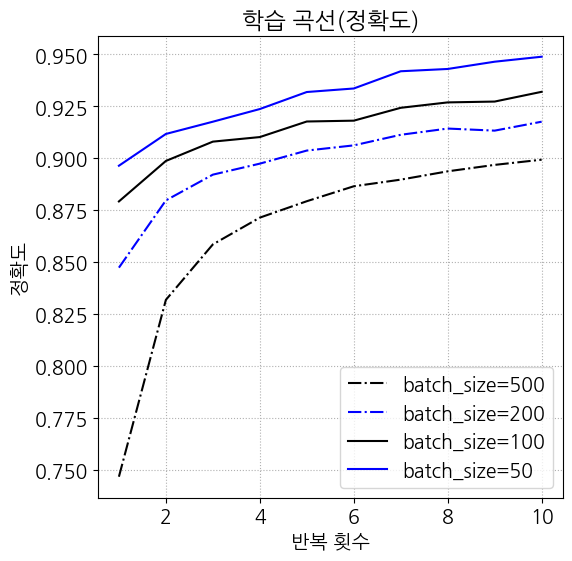

In [ ]:
# 학습 곡선 출력(정확도)

plt.plot(history[:,0], history[:,4], label='batch_size=500', c='k', linestyle='-.')
plt.plot(history3[:,0], history3[:,4], label='batch_size=200', c='b', linestyle='-.')
plt.plot(history4[:,0], history4[:,4], label='batch_size=100', c='k')
plt.plot(history5[:,0], history5[:,4], label='batch_size=50', c='b')
plt.xlabel('반복 횟수')
plt.ylabel('정확도')
plt.title('학습 곡선(정확도)')
plt.legend()
plt.show()